#Quora Question Pairs
## Business Problem
### Description ::: 
Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.


Credits: Kaggle

### Problem Statement

* Identify which questions asked on Quora are duplicates of questions that have already been asked.
* This could be useful to instantly provide answers to questions that have already been answered.
* We are tasked with predicting whether a pair of questions are duplicates or not.

### Sources/Useful Links
* Source : https://www.kaggle.com/c/quora-question-pairs 

* Useful Links
* Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
* Kaggle Winning Solution and other approaches:    * https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
* Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
* Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

### Real world/Business Objectives and Constraints
* The cost of a mis-classification can be very high.
* You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
* No strict latency concerns.
* Interpretability is partially important.

#  Machine Learning Probelm
##  Data
###  Data Overview
- Data will be in a file Train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of Train.csv - 60MB 
- Number of rows in Train.csv = 404,290

###  Example Data point
- "id","qid1","qid2","question1","question2","is_duplicate"
- "0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
- "1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
- "7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
- "11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"

## Mapping the real world problem to an ML problem
### Type of Machine Leaning Problem
- It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

### Performance Metric
- Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

### Metric(s):

1. log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
2. Binary Confusion Matrix

### Importing Libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#from subprocess import check_output
#%matplotlib inline
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as goRandom train test split( 70:30)
#import plotly.tools as tls
#import os
#import gc

import re
from nltk.corpus import stopwords
#import distance
#from nltk.stem import PorterStemmer
#from bs4 import BeautifulSoup

### Mounting data from google collab to google drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "/content/drive/My Drive/QuoraSimilarQuestions/Quora/train.csv" "train.csv"

### Reading csv data into dataframe

In [0]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [0]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


# Distribution of data points among output classes


### 0 : Represents both Question1 and Question2   are not similar
### 1 : Represents both Question1 and Question2   are  similar

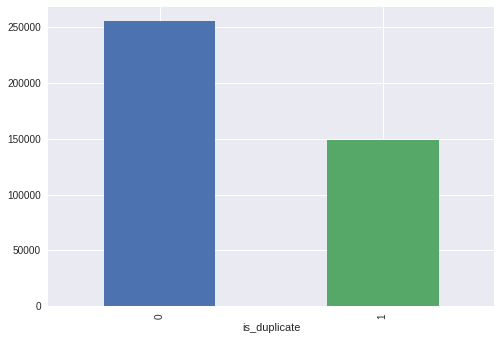

In [0]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [0]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Total number of question pairs for training:
   404290
~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
print(len(np.unique(qids)))
qids.shape
808580-537933

537933


270647

In [0]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 



Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



Maximum number of times a single question is repeated: 157



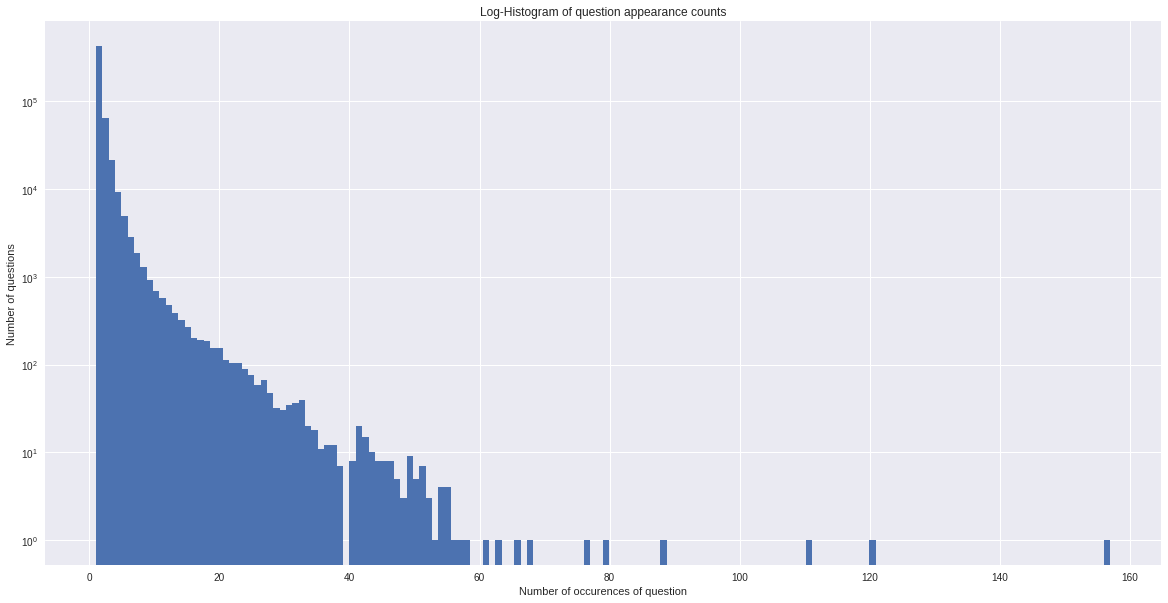

In [0]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

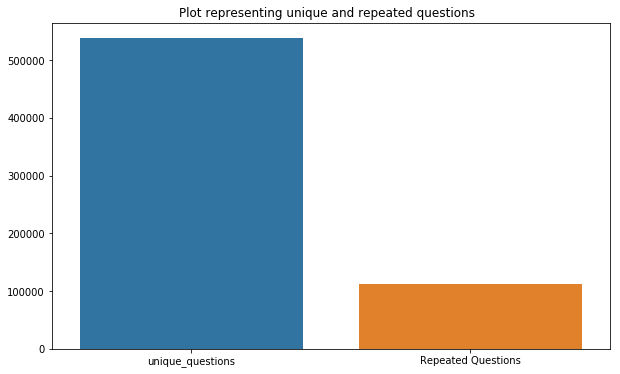

In [0]:
 x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [0]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


In [0]:
nan_rows = df.isnull().sum()
print (nan_rows)

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64


In [0]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  \
105780                                                NaN             0   
201841                                                NaN             0   
363362  My Chinese name is Haichao Yu. What English na...             0   

        freq_qid1  freq_qid2  q1len  q2len  
105780          2          2   30.0    NaN  
201841          1          2   32.0    NaN  
363362          1          1    NaN  123.0  


In [0]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate, freq_qid1, freq_qid2, q1len, q2len]
Index: []


# Basic Feature Extraction (before cleaning)


Let us now construct a few features like:

- freq_qid1 = Frequency of qid1's
- freq_qid2 = Frequency of qid2's
- q1len = Length of q1
- q2len = Length of q2
- q1_n_words = Number of words in Question 1
- q2_n_words = Number of words in Question 2
- word_Common = (Number of common unique words in Question 1 and Question 2)
- word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
- word_share = (word_common)/(word_Total)
- freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
- freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [0]:
import os
if os.path.isfile('df_fe_without_preprocessing_train.csv'): ## it will check whether df_fe_without_preprocessing_train.csvpresent in OS are not
  
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [0]:
df.to_pickle("/content/drive/My Drive/df_fe_without_preprocessing_train.pkl")

In [0]:
df=pd.read_pickle("/content/drive/My Drive/df_fe_without_preprocessing_train.pkl")

In [0]:
df1.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


In [0]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


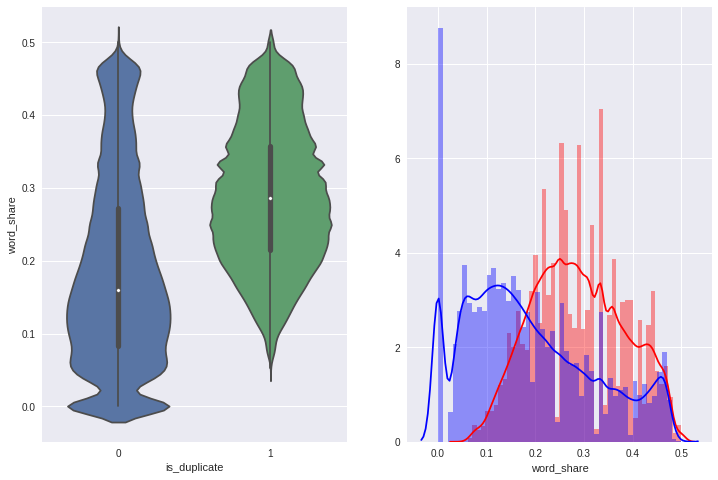

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = df['is_duplicate'], y = df['word_share'])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

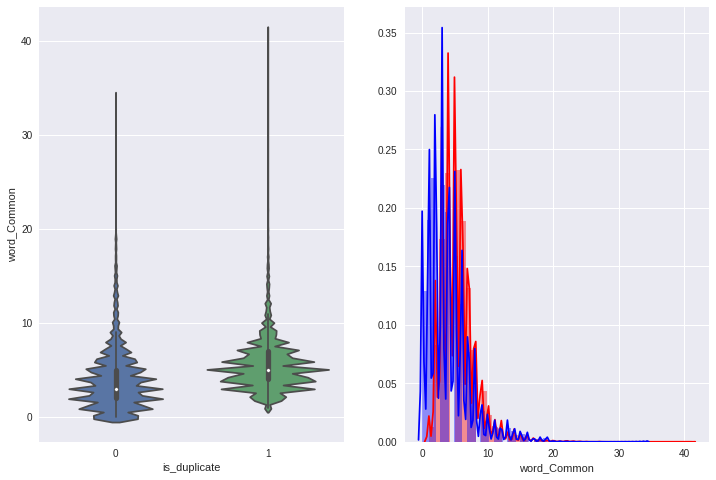

In [0]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

In [0]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [0]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


# Preprocessing of Text

- Preprocessing:
   - Removing html tags
   - Removing Punctuations
   - Performing stemming
   - Removing Stopwords
   - Expanding contractions etc.

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 
STOP_WORDS = stopwords.words("english")

def preprocess(x):
    #print(x)
    x = str(x).lower()
    #print(x)
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    #print(x)
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        #print(x)
        x = re.sub(pattern, ' ', x)
        #print(x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
                   
    return x
    

- Definition:

   - Token: You get a token by splitting sentence a space
   - Stop_Word : stop words as per NLTK.
   - Word : A token that is not a stop_word
- Features:
   
   - cwc_min : Ratio of common_word_count to min lenghth of word count of Q1 and Q2 
   - cwc_min = common_word_count / (min(len(q1_words), len(q2_words)) 
   - 
   - cwc_max : Ratio of common_word_count to max lenghth of word count of Q1 and Q2 
   - cwc_max = common_word_count / (max(len(q1_words), len(q2_words)) 
   - 
   - csc_min : Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 
   - csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops)) 
   - 
   - csc_max : Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2
   - csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops)) 
   - 
   - ctc_min : Ratio of common_token_count to min lenghth of token count of Q1 and Q2
   - ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens)) 
   
    
   - ctc_max : Ratio of common_token_count to max lenghth of token count of Q1 and Q2
   - ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens)) 
    
    
   - last_word_eq : Check if First word of both questions is equal or not
   - last_word_eq = int(q1_tokens[-1] == q2_tokens[-1]) 
    
    
   - first_word_eq : Check if First word of both questions is equal or not
   - first_word_eq = int(q1_tokens[0] == q2_tokens[0]) 
    
    
   - abs_len_diff : Abs. length difference
   - abs_len_diff = abs(len(q1_tokens) - len(q2_tokens)) 
    
    
   - mean_len : Average Token Length of both Questions
   - mean_len = (len(q1_tokens) + len(q2_tokens))/2 
    
    
   - fuzz_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 
   
    
   - fuzz_partial_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/   - fuzzywuzzy-fuzzy-string-matching-in-python/    - 
    
    
   - token_sort_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/   - fuzzywuzzy-fuzzy-string-matching-in-python/    - 
    
   - token_set_ratio : https://github.com/seatgeek/fuzzywuzzy#usage http://chairnerd.seatgeek.com/   - fuzzywuzzy-fuzzy-string-matching-in-python/    - 
    
   - longest_substr_ratio : Ratio of length longest common substring to min lenghth of token count of Q1 and Q2
   - longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))   - 

In [0]:
!pip install Distance
!pip install fuzzywuzzy

In [0]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
#%matplotlib inline
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [0]:
df.to_pickle("/content/drive/My Drive/nlp_features_train.pkl")

In [0]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [0]:
df.to_pickle("/content/drive/My Drive/nlp_features_train.pkl")

In [0]:
df1.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [0]:
df1=pd.read_pickle("/content/drive/My Drive/nlp_features_train.pkl")
df1.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667


In [0]:
df.isnull().any().sum()

0

## Analysis of extracted features

 ## Plotting Word clouds

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [0]:
np.dstack([df1["qid1"], df1["qid2"]])#.flatten()

array([[[     1,      2],
        [     3,      4],
        [     5,      6],
        ...,
        [537928, 537929],
        [537930, 537931],
        [537932, 537933]]])

In [0]:
np.dstack([df1["qid1"], df1["qid2"]]).flatten()

array([     1,      2,      3, ..., 537931, 537932, 537933])

In [0]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [0]:
d = path.dirname('.')
a=open(path.join(d, 'train_p.txt')).read()

In [0]:
a[:1000]

'astrology  i am a capricorn sun cap moon and cap rising   what does that say about me \ni am a triple capricorn  sun  moon and ascendant in capricorn  what does this say about me \nhow can i be a good geologist \nwhat should i do to be a great geologist \nhow do i read and find my youtube comments \nhow can i see all my youtube comments \nwhat can make physics easy to learn \nhow can you make physics easy to learn \nwhat was your first sexual experience like \nwhat was your first sexual experience \nwhat would a trump presidency mean for current international master own students on an f1 visa \nhow will a trump presidency affect the students presently in us or planning to study in us \nwhat does manipulation mean \nwhat does manipulation means \nwhy are so many quora users posting questions that are readily answered on google \nwhy do people ask quora questions which can be answered easily by google \nwhy do rockets look white \nwhy are rockets and boosters painted white \nhow should 

In [0]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
stopwords.remove("like")

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16110763
Total number of words in non duplicate pair questions : 33201102


## Word Clouds generated from duplicate pair question's text

Word Cloud for Duplicate Question pairs


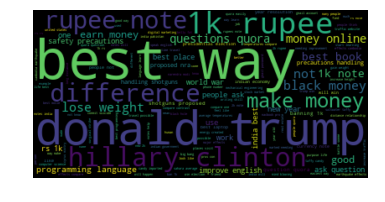

In [0]:
wc = WordCloud(background_color="black", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()


## Word Clouds generated from non duplicate pair question's text

Word Cloud for non-Duplicate Question pairs:


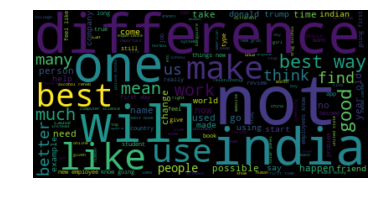

In [0]:
wc = WordCloud(background_color="black", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio']

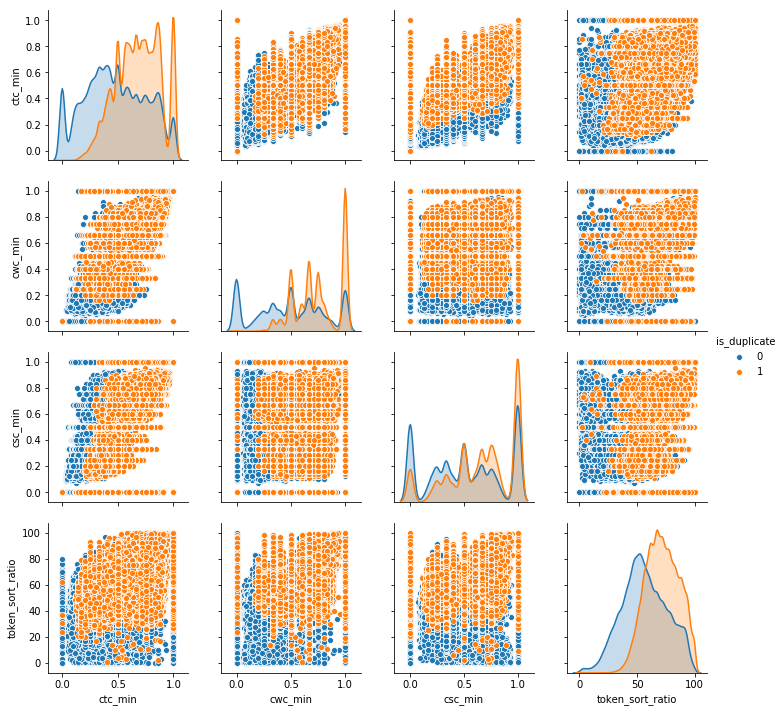

In [0]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

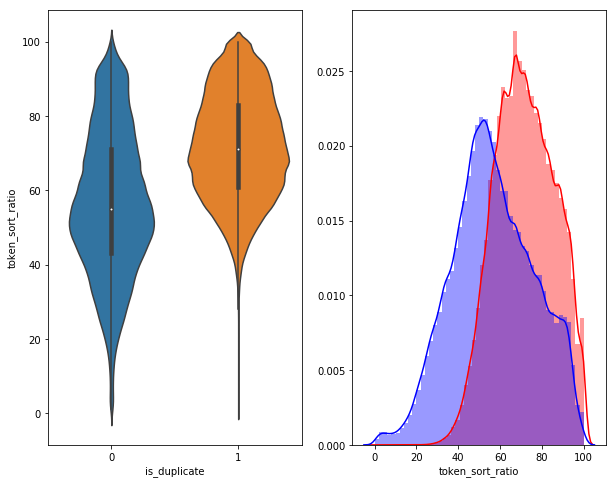

In [0]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

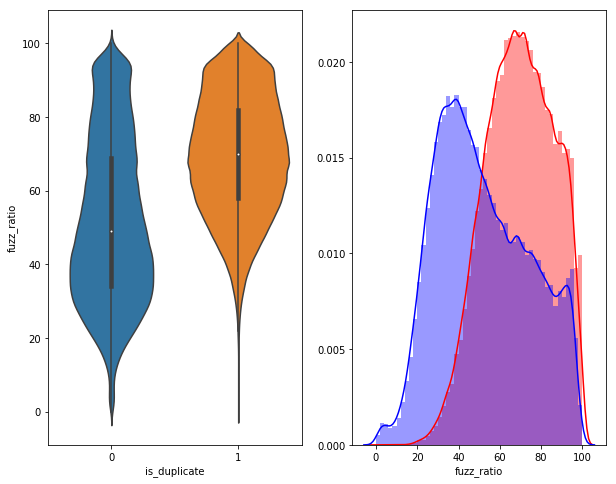

In [0]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

#  Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [0]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.061s...
[t-SNE] Computed neighbors for 5000 samples in 0.462s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.625s
[t-SNE] Iteration 50: error = 81.2911148, gradient norm = 0.0457501 (50 iterations in 3.053s)
[t-SNE] Iteration 100: error = 70.6044159, gradient norm = 0.0086692 (50 iterations in 2.171s)
[t-SNE] Iteration 150: error = 68.9124908, gradient norm = 0.0056016 (50 iterations in 2.029s)
[t-SNE] Iteration 200: error = 68.1010742, gradient norm = 0.0047585 (50 iterations in 2.111s)
[t-SNE] Iteration 250: error = 67.5907974, gradient norm = 0.0033576

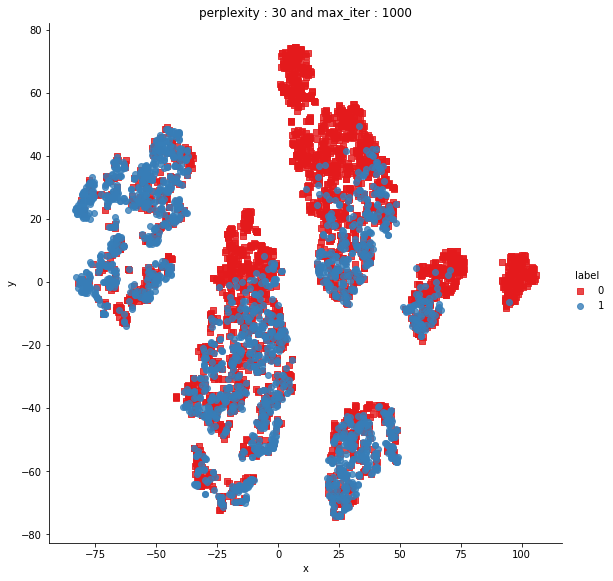

In [0]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.018s...
[t-SNE] Computed neighbors for 5000 samples in 0.458s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.369s
[t-SNE] Iteration 50: error = 80.5316772, gradient norm = 0.0296611 (50 iterations in 16.691s)
[t-SNE] Iteration 100: error = 69.3834763, gradient norm = 0.0033837 (50 iterations in 9.931s)
[t-SNE] Iteration 150: error = 67.9741974, gradient norm = 0.0017825 (50 iterations in 9.146s)
[t-SNE] Iteration 200: error = 67.4170685, gradient norm = 0.0011107 (50 iterations in 9.241s)
[t-SNE] Iteration 250: error = 67.1046600, gradient norm = 0.001052

In [0]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

#  Featurizing text data with tfidf weighted word-vectors

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
# avoid decoding problems
df = pd.read_csv("train.csv")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
df['q1q2']=df[['question1', 'question2']].apply(lambda x: ' '.join(x), axis=1)
df['q1q2'][1]

'What is the story of Kohinoor (Koh-i-Noor) Diamond? What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?'

In [0]:
from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df['q1q2'],  test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003,)
Number of data points in test data : (121287,)


In [0]:
tf_idf_vect = TfidfVectorizer( min_df=10, max_df=0.90,stop_words='english',max_features=100 )
tf_idf_vect.fit(X_train) # fit has to happen only on train data
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)

print("After vectorizations")
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print("="*100)

some sample features(unique words in the corpus) ['10', '1000', '2016', '500', 'account', 'android', 'app', 'best', 'better', 'black']
After vectorizations
(283003, 100)
(121287, 100)


In [0]:
type(X_train_tfidf)

scipy.sparse.csr.csr_matrix

In [0]:
#dummy=pd.concat([X_train_tfidf.toarray(),X_test_tfidf.toarray()],axis=0)
dummy_train = pd.DataFrame(X_train_tfidf.toarray(), columns=tf_idf_vect.get_feature_names())
dummy_test = pd.DataFrame(X_test_tfidf.toarray(), columns=tf_idf_vect.get_feature_names())
print(dummy_train.shape ,  dummy_test.shape)

(283003, 100) (121287, 100)


In [0]:
dummy=pd.concat([dummy_train,dummy_test],axis=0)
dummy.shape

(404290, 100)

In [0]:
q1_vector = pd.DataFrame(X_train_tfidf.toarray(), columns=tf_idf_vect.get_feature_names() )
q2_vector = pd.DataFrame(X_test_tfidf.toarray(), columns=tf_idf_vect.get_feature_names())

q1q2_vector=pd.concat([q1_vector,q2_vector],axis=0)
q1q2_vector.shape

(404290, 100)

In [0]:
q1q2_vector=q1q2_vector.reset_index(drop=True)

In [0]:
df4 = df3.reindex_axis(df.columns, axis=1)

In [0]:
q1q2_vector.index

RangeIndex(start=0, stop=404290, step=1)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [0]:
sorted(word2tfidf.values())

[1.9822644822088766,
 1.9903590341780564,
 2.358536363861665,
 2.391926201462379,
 2.50063654431769,
 2.5273854392328445,
 2.726982595928211,
 2.7501231940591,
 2.822934925921036,
 2.906140476500113,
 3.1172763416123614,
 3.1929078107942583,
 3.3272010309864264,
 3.416007032428632,
 3.454429039863603,
 3.5478853817727587,
 3.6248021684075646,
 3.6484472799766348,
 3.7378639268096525,
 3.9249366324314754,
 3.950446493269301,
 3.9657154201423306,
 3.9792484074212426,
 4.038201717963545,
 4.067027589731403,
 4.070806602106084,
 4.078246555067091,
 4.1056694070724165,
 4.140904698752227,
 4.181856589790424,
 4.227172772582902,
 4.274607701364872,
 4.4007040463158,
 4.403005885089716,
 4.43668444646455,
 4.46720746230544,
 4.478206656606111,
 4.504804509181181,
 4.528161594232518,
 4.566373506821276,
 4.671641632720685,
 4.6889054258752125,
 4.696353695077173,
 4.710356784690296,
 4.7201084999390535,
 4.7357458742855805,
 4.767613316887822,
 4.771689263751375,
 4.772549478858183,
 4.7900752

In [0]:
#TFIDF

In [0]:
df['q1q2']=df[['question1', 'question2']].apply(lambda x: ' '.join(x), axis=1)


from sklearn.model_selection import train_test_split
X_train,X_test = train_test_split(df['q1q2'],  test_size=0.3)


tf_idf_vect = TfidfVectorizer( min_df=10, max_df=0.90,stop_words='english',max_features=100 )
tf_idf_vect.fit(X_train) # fit has to happen only on train data
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])

X_train_tfidf = tf_idf_vect.transform(X_train)
X_test_tfidf = tf_idf_vect.transform(X_test)


q1_vector = pd.DataFrame(X_train_tfidf.toarray(), columns=tf_idf_vect.get_feature_names() ,index=df.index)
q2_vector = pd.DataFrame(X_test_tfidf.toarray(), columns=tf_idf_vect.get_feature_names())

q1q2_vector=pd.concat([q1_vector,q2_vector],axis=0)
q1q2_vector=q1q2_vector.reset_index(drop=True)
q1q2_vector.shape

q1q2_vector.index
df.index

KeyError: ignored

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy". https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics.

In [0]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


 94%|█████████▍| 379942/404290 [1:09:37<04:30, 90.01it/s] 

In [0]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

In [0]:
!cp "/content/drive/My Drive/QuoraSimilarQuestions/Quora/nlp_features_train.csv" "nlp_features_train.csv"
!cp "/content/drive/My Drive/QuoraSimilarQuestions/Quora/df_fe_without_preprocessing_train.csv" "df_fe_without_preprocessing_train.csv"

In [0]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [0]:
df1.columns.values

array(['id', 'is_duplicate', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype=object)

In [0]:
df2.columns.values

array(['id', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2'], dtype=object)

In [0]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", q1q2_vector.shape[1])
#print("Number of features in question2 w2v  dataframe :", dummy.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+dummy.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 100
Number of features in final dataframe  : 129


In [0]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    #df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Machine Learning Models

## Reading data from file and storing into sql table

In [0]:
#Creating db file from csv
if not os.path.isfile('train_tfidf.db'):
    disk_engine = create_engine('sqlite:///train_tfidf.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features_tfidf_100.csv',  chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [0]:
!cp "/content/drive/My Drive/QuoraSimilarQuestions/Quora/train_tfidf.db" "train_tfidf.db"

cp: cannot stat '/content/drive/My Drive/QuoraSimilarQuestions/Quora/train_tfidf.db': No such file or directory


In [0]:
read_db = 'train_tfidf.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the databse:
data


In [0]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ORDER BY RANDOM() LIMIT 100001;", conn_r)
        conn_r.commit()
        conn_r.close()

## Converting strings to numerics

In [0]:

# after we read from sql table each entry was read it as a string
# we convert all the features into numaric before we apply any model
cols = list(data.columns)
for i in cols:
    print(i)
    data[i] = data[i].apply(pd.to_numeric)
    print(i)

In [0]:
# https://stackoverflow.com/questions/7368789/convert-all-strings-in-a-list-to-int
#y_true = list(map(int, y_true.values))
y_true = [int(i) for i in y_true.values]

In [0]:

df1 = dfnlp.drop(['qid1','qid2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

df  = df1.merge(df2, on='id',how='left')

In [0]:
df.head(2)


,id,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,...,1,51,88,8,13,4.0,20.0,0.200000,5,3


In [0]:
#Remove the first row 
#data.drop(data.index[0], inplace=True)
y_true = df['is_duplicate']
df.drop(['id','is_duplicate'], axis=1, inplace=True)

# Random train test split( 70:30)¶

In [0]:
X_train,X_test, y_train, y_test = train_test_split(df, y_true, stratify=y_true, test_size=0.3)
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (283003, 28)
Number of data points in test data : (121287, 28)


In [0]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6308025003268517 Class 1:  0.36919749967314835
---------- Distribution of output variable in train data ----------
Class 0:  0.3691986775169639 Class 1:  0.3691986775169639


In [0]:
!cp "/content/drive/My Drive/QuoraSimilarQuestions/Quora/train.csv" "train.csv"

In [0]:
train_q1_tfidf = tfidf_vect1.fit_transform(X_train['question1'].values.astype('U'))
test_q1_tfidf = tfidf_vect1.transform(X_test['question1'].values.astype('U'))

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


tf_idf_vect_q1 = TfidfVectorizer(max_df=0.95, min_df=2,stop_words='english',max_features=1000) #in scikit-learn


train_q1_tfidf = tf_idf_vect_q1.fit_transform(X_train['question1'].values.astype('U'))
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text BOW vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words ", X_train_tfidf.get_shape()[1])

test_q2_tfidf = tf_idf_vect_q1.transform(X_train['question1'].values.astype('U'))
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text BOW vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words ", X_test_tfidf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (283003, 100)
the number of unique words  100
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (121287, 100)
the number of unique words  100


In [0]:
#Tfidf Vectorizer for Question-1  , Here Considering all words or tokens as the dimensions
from sklearn.feature_extraction.textimport TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_vect_q1 = TfidfVectorizer()

train_q1_tfidf = tfidf_vect_q1.fit_transform(X_train['question1'].values.astype('U'))
test_q1_tfidf = tfidf_vect_q1.transform(X_test['question1'].values.astype('U'))

In [0]:
train_q1_tfidf.shape,test_q1_tfidf.shape

((283003, 58087), (121287, 58087))

In [0]:
#Tfidf Vectorizer for Question-2 ,  , Here Considering all words or tokens as the dimensions
tfidf_vect_q2 = TfidfVectorizer()

train_q2_tfidf = tfidf_vect_q2.fit_transform(X_train['question2'].values.astype('U'))
test_q2_tfidf = tfidf_vect_q2.transform(X_test['question2'].values.astype('U'))

In [0]:
train_q2_tfidf.shape , test_q2_tfidf.shape

((283003, 53503), (121287, 53503))

In [0]:
# After TfidfVectorizer using , now each Question1 consists of 58087 Dimensions
# After TfidfVectorizer using , now each Question2 consists of 53503 Dimensions
#  Question1 + Question2 ie we (58087 + 53503) Dimensions 

#Combining Question-1 and Question-2 using  hstack function
train_tfidf = hstack((train_q1_tfidf,train_q2_tfidf))
test_tfidf = hstack((test_q1_tfidf,test_q2_tfidf))

In [0]:

#Dropping question-1 and question-2 and Replacing with tfidf values
X_train.drop(['question1','question2'], axis=1, inplace=True)
X_test.drop(['question1','question2'], axis=1, inplace=True)

In [0]:
#Combining all train nlp features, adv features and tfidf features
X_train = hstack((X_train, train_tfidf)).tocsr()
#Combining all test nlp features, adv features and tfidf features
X_test = hstack((X_test, test_tfidf)).tocsr()

In [0]:
print(X_train.shape)
print(X_test.shape)

(283003, 111616)
(121287, 111616)


# Ploting Confusion Matrix

In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")
def plot_confusion_matrix(test_y, predict_y):
    
    C = confusion_matrix(test_y, predict_y)
    print(C)
    
    A =(((C.T)/(C.sum(axis=1))).T)
   
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    
    cmap=sns.light_palette("blue")
    
    plt.subplot(1, 3, 1)
    #sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    sns.heatmap(C, annot=True, cmap= "RdBu_r", fmt=".3f", xticklabels=labels, yticklabels=labels)
    
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap= "RdBu_r", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap= "RdBu_r", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

# Building a random model (Finding worst-case log-loss)

In [0]:
#predicted_y.shape
y_test=np.array(y_test)

Log loss on Test Data using Random Model 0.8853109073013328
[[38335 38173]
 [22409 22370]]


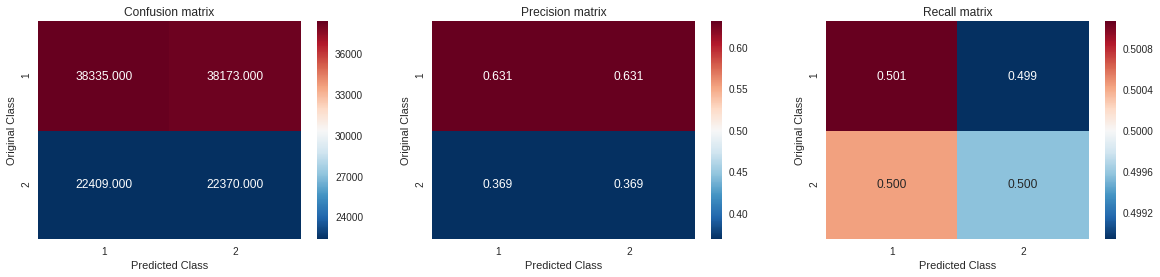

In [0]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

# Logistic Regression with hyperparameter tuning

In [0]:
# applying column standardization on train and test data
from sklearn.preprocessing import StandardScaler

standard_scalar=StandardScaler(with_mean=False)
X_train=standard_scalar.fit_transform(X_train)
X_test=standard_scalar.transform(X_test)

For values of alpha =  1e-05 The log loss is: 0.5320271658569719
For values of alpha =  0.0001 The log loss is: 0.5326176278462595
For values of alpha =  0.001 The log loss is: 0.532406947959182
For values of alpha =  0.01 The log loss is: 0.48975046388535354
For values of alpha =  0.1 The log loss is: 0.42193717955461746
For values of alpha =  1 The log loss is: 0.4427643356995551
For values of alpha =  10 The log loss is: 0.5071952472897591


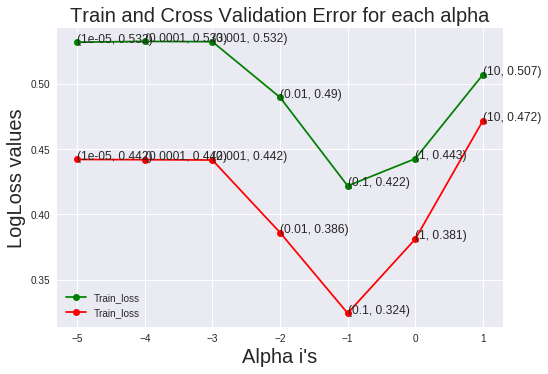

For values of best alpha =  0.1 The train log loss is: 0.3243674506780962
For values of best alpha =  0.1 The test log loss is: 0.42193717955461746
Total number of data points : 121287
[[66589  9919]
 [14526 30253]]


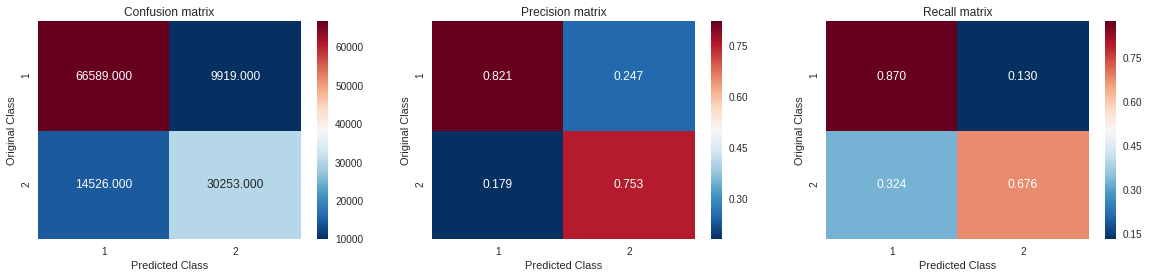

In [0]:
import math
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
log_error_array_train=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    predict_y_train = sig_clf.predict_proba(X_train)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    log_error_array_train.append(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

alpha_lg=[math.log10(i) for i in alpha]

fig, ax = plt.subplots()

ax.plot(alpha_lg, log_error_array,c='g',label="Train_loss",marker='o')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha_lg[i],log_error_array[i]))
    
ax.plot(alpha_lg, log_error_array_train,c='r',label="Train_loss",marker='o')
for i, txt in enumerate(np.round(log_error_array_train,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha_lg[i],log_error_array_train[i]))
    
plt.title("Train and Cross Validation Error for each alpha",fontsize=20)
plt.xlabel("Alpha i's",fontsize=20)
plt.ylabel("LogLoss values",fontsize=20)
#plt.legend()
plt.legend(loc='lower left')
plt.show()   
    

best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

# Linear SVM with hyperparameter tuning

For values of alpha =  1e-05 The log loss is: 0.5419762485546377
For values of alpha =  0.0001 The log loss is: 0.5541947166160284
For values of alpha =  0.001 The log loss is: 0.6029800453323112
For values of alpha =  0.01 The log loss is: 0.6549013409125523
For values of alpha =  0.1 The log loss is: 0.6584170433691283
For values of alpha =  1 The log loss is: 0.6584693028967472
For values of alpha =  10 The log loss is: 0.6584627825710958


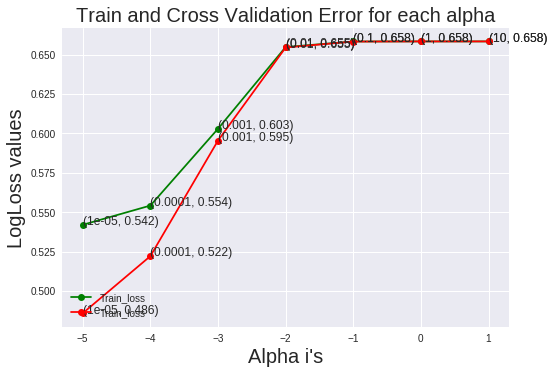

For values of best alpha =  1e-05 The train log loss is: 0.48580653109352395
For values of best alpha =  1e-05 The test log loss is: 0.5419762485546377
Total number of data points : 121287
[[71804  4704]
 [29047 15732]]


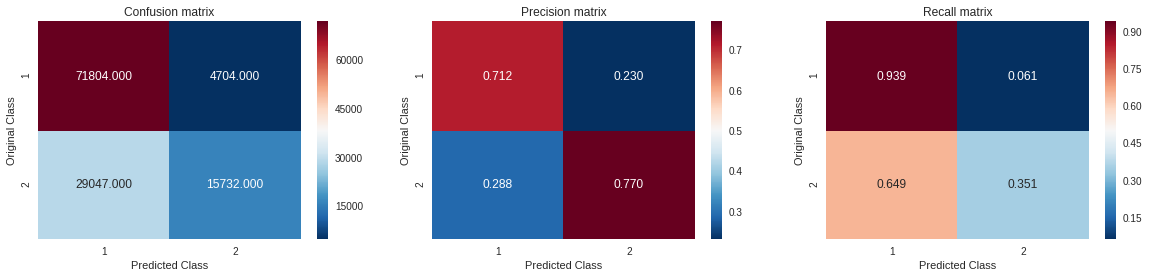

In [0]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
log_error_array_train=[]

for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y_train = sig_clf.predict_proba(X_train)
    log_error_array_train.append(log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
    #predict_y_train = sig_clf.predict_proba(X_train)
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


alpha_lg=[math.log10(i) for i in alpha]
alpha_lg

fig, ax = plt.subplots()

ax.plot(alpha_lg, log_error_array,c='g',label="Train_loss",marker='o')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha_lg[i],log_error_array[i]))
    
ax.plot(alpha_lg, log_error_array_train,c='r',label="Train_loss",marker='o')
for i, txt in enumerate(np.round(log_error_array_train,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha_lg[i],log_error_array_train[i]))
    
plt.title("Train and Cross Validation Error for each alpha",fontsize=20)
plt.xlabel("Alpha i's",fontsize=20)
plt.ylabel("LogLoss values",fontsize=20)
plt.legend(loc='lower left')
plt.show()



best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

#  XGBoost

In [0]:
import xgboost as xgb
#dtrain = xgb.DMatrix(X_train_xg.values, label=y_train_xg.values)
#dtest = xgb.DMatrix(X_test_xg.values, label=y_test_xg.values)
param_test1 = {
'max_depth': [2,4],
'min_child_weight':[2,4],
'reg_alpha':[0.001]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =
0.1, n_estimators=140, max_depth=5,
min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27),
param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y_train)
#gsearch1.cv_results_
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0.001},
 0.9188705470167051)

For values of best alpha =  1e-05 The train log loss is: 0.3540795852047962
For values of best alpha =  1e-05 The test log loss is: 0.35933537334756815
Total number of data points : 121287
[[68191  8317]
 [12747 32032]]


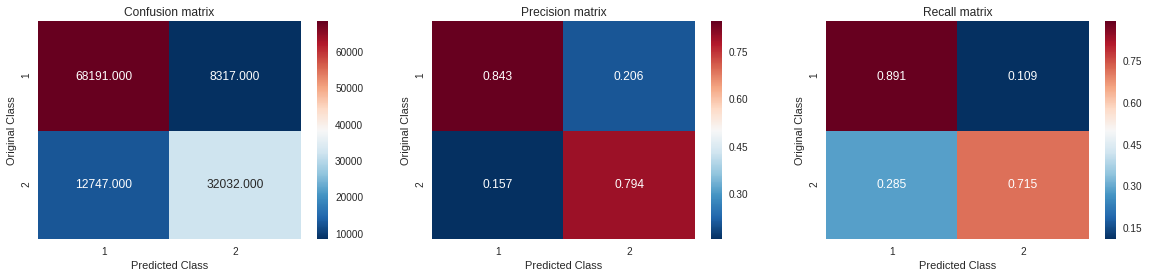

In [0]:
clf1=xgb.XGBClassifier(min_child_weight=gsearch1.best_params_['min_child_weight'],max_depth=gsearch1.best_params_['max_depth'],reg_alpha=gsearch1.best_params_['reg_alpha'])
clf1.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf1, method="sigmoid" ,cv= 5)
sig_clf.fit(X_train, y_train)
            
predict_y_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y_train, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## Results Comparsion

In [0]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["ALGO" , "HyperParameter" , 'Train_LogLoss','Test_LogLoss']

x.add_row([ "RandomModel " , '----','-------' , 0.8853 ])     
x.add_row([ "Logistic Regression " , {'alpha' : 0.1 }  , 0.3243 , 0.4219 ])
x.add_row([ "Linear SVM" , {'alpha' :0.00001} , 0.4858, 0.5419 ])
x.add_row([ "XGBost" , {'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0.001} , 0.3540, 0.3593 ])

print(x)

+----------------------+-------------------------------------------------------------+---------------+--------------+
|         ALGO         |                        HyperParameter                       | Train_LogLoss | Test_LogLoss |
+----------------------+-------------------------------------------------------------+---------------+--------------+
|     RandomModel      |                             ----                            |    -------    |    0.8853    |
| Logistic Regression  |                        {'alpha': 0.1}                       |     0.3243    |    0.4219    |
|      Linear SVM      |                       {'alpha': 1e-05}                      |     0.4858    |    0.5419    |
|        XGBost        | {'max_depth': 4, 'min_child_weight': 2, 'reg_alpha': 0.001} |     0.354     |    0.3593    |
+----------------------+-------------------------------------------------------------+---------------+--------------+


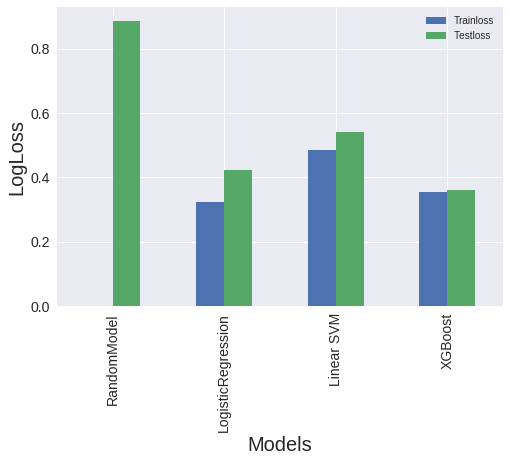

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
a=pd.DataFrame([ ['RandomModel',0,0.8853],['LogisticRegression', 0.3243, 0.4219] , ['Linear SVM', 0.4858,  0.5419 ] ,['XGBoost', 0.3540, 0.3593]],
               columns=["MODELS",'Trainloss','Testloss'],
               )
a.set_index('MODELS', inplace=True)
a.plot(kind='bar')
plt.xlabel("Models",fontsize=20)
plt.ylabel("LogLoss",fontsize=20)
plt.xticks(fontsize=14) #rotation=90)
plt.yticks(fontsize=14)

plt.show()

## Summary
* we have done FeatureEngineering on the given data :
  * with Basic FeatureEngineering we found some features
  * with someComplex FeatureEngineering (techniques for NLP like Fuzzywords etc are used)  and  found some more features
* now we have feaures like  question1 and question2 along  with new features (which we got by feature Engineering Technique) 

* now combine all features ie (q1,q2 Features + new features(from Featureengineering))
* Next we Converted  the question1,question2 TEXT Feature Data to  TFIDF Vectores and added to the new features data.and your Data got Prepared
* then  splited that data into train and text data
and then applied Machine Learning Models
#### Among those models :
* XGBoost has less LogLoss compared to other models
* XGBoost Train_LogLoss and Test_LogLoss values are very close.so, there is no chance of overfit or underfit in the data
* Compared to other model LinerSVM  has more log loss value
